In [4]:
import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
from work_in_graph import *
from usefull_little_functions import *
import numpy as np


/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Creating a little ontology (LO)
Creating ontology from adjacency tensors. The ontology is given under this form when one work with pyTorch.

/!\ CHECK THAT THE ONTOLOGY IN ORIENTED AS LO_EDGE_INDEX, that is to say that more specific nodes are children of less specific nodes. If not, swap the two parts of the ontology edge index (here thoses parts are commented Departure nodes and Arrival nodes)

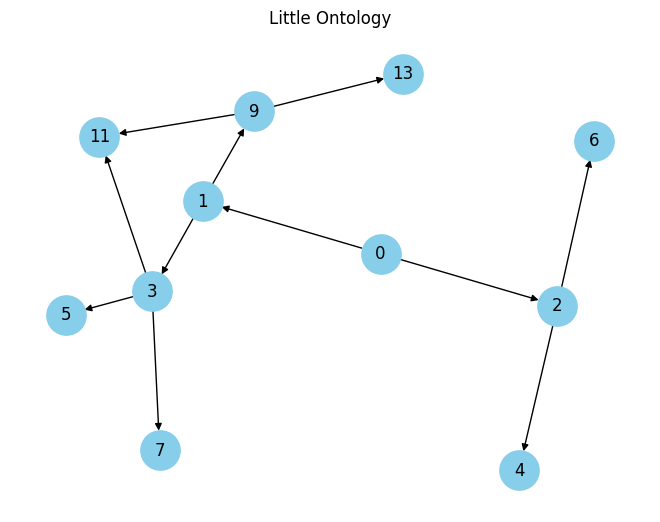

In [56]:
LO_edge_index = torch.tensor([[0,0,1,1,2,2,3,3,9, 9, 3],  # Departure nodes
                              [1,2,3,9,4,6,5,7,11,13, 11]], # Arrival nodes
                              dtype=torch.long)

def plot_graph(edge_index, tittle = "Graph"):
    G = nx.DiGraph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G, iterations=50, seed = 4)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    plt.title(tittle)
    plt.show()

plot_graph(LO_edge_index, tittle="Little Ontology")


# Rerieving leaves

In [68]:
def DFS(G, v, discovered):
    """
    Effectue une recherche en profondeur (DFS) dans un graphe dirigé.

    Args:
    G (nx.DiGraph): Le graphe dirigé dans lequel effectuer la DFS.
    v: Le nœud de départ pour la DFS.
    discovered (set): Un ensemble pour suivre les nœuds découverts.

    """
    discovered.add(v)  # Marquer v comme découvert

    for w in G.predecessors(v):  # Parcourir tous les successeurs (arêtes dirigées) de v
        if w not in discovered:  # Si le nœud w n'est pas encore découvert
            DFS(G, w, discovered)  # Appel récursif de DFS sur w

    return discovered


def get_leaves_and_ancestors(edge_index:torch.Tensor):

    # 1 - Listing nodes of the ontology :
    all_nodes: list = list(set(edge_index.tolist()[0]+ edge_index.tolist()[1])) # Lists all elements of the edge_index

    # 2 - Iniating an nx.graph from edge_index :
    G = nx.DiGraph()
    G.add_edges_from(edge_index.t().tolist())

    # 3 - For each node, if node has no children, add node to the list of the leaves :
    leaves: list = []
    for node in tqdm(all_nodes, desc = "Retrieving leaves from ontology") :
        if len(list(G.successors(node)))==0:
            leaves.append(node)

    # 4 - Associates each leave and its ancestors in a dict <leave> : [ancestors]
    leaves_and_ancestors = dict()
    for leave in tqdm(leaves, desc = "Retrieving ancestors of each leave."):
        discovered = set()
        leaves_and_ancestors[leave]=DFS(G, leave, discovered)

    return leaves_and_ancestors

get_leaves_and_ancestors(LO_edge_index)

Retrieving ancestors of each leave.: 100%|██████████| 6/6 [00:00<00:00, 44938.97it/s]


{4: {0, 2, 4},
 5: {0, 1, 3, 5},
 6: {0, 2, 6},
 7: {0, 1, 3, 7},
 11: {0, 1, 3, 9, 11},
 13: {0, 1, 9, 13}}

# Retrieving leaves ancestors

In [61]:
def get_ancestors(edge_index:torch.Tensor, nodes: list):

    # 1 - Iniating an nx.graph from edge_index :
    G = nx.DiGraph()
    G.add_edges_from(edge_index.t().tolist())
    for node in nodes :
        print(G.predecessors(nodes))
              
get_ancestors(LO_edge_index, [11])

TypeError: unhashable type: 'list'

# Training models

# Comparing ontologies comprehension of the trained models